**Содержание**<a id='toc0_'></a>    
- [Защита персональных данных клиентов](#toc1_)    
  - [Загрузка данных](#toc1_1_)    
    - [Импорт библиотек](#toc1_1_1_)    
    - [Загрузка данных](#toc1_1_2_)    
    - [Вывод](#toc1_1_3_)    
  - [Умножение матриц](#toc1_2_)    
      - [**Ответ:**](#toc1_2_1_1_)    
  - [Алгоритм преобразования](#toc1_3_)    
  - [Проверка алгоритма](#toc1_4_)    
      - [Вывод](#toc1_4_1_1_)    
  - [Вывод](#toc1_5_)    
  - [Чек-лист проверки](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>Защита персональных данных клиентов [](#toc0_)

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Описание данных

* Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.
* Целевой признак: количество страховых выплат клиенту за последние 5 лет.

## <a id='toc1_1_'></a>Загрузка данных [](#toc0_)

### <a id='toc1_1_1_'></a>Импорт библиотек [](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
%matplotlib inline

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
class matrix_transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y = None):
        while hasattr(self, 'key_encoding') == False:
            key_encoding = np.random.randn(X.shape[1], X.shape[1])
            try: 
                key_decoding = np.linalg.inv(key_encoding)
                self.key_encoding = key_encoding
            except:
                continue
        return self

    def transform(self, X, y = None):
        X_ = X.copy()
        X_ = X @ self.key_encoding
        return X_
    

class protection_info():
    

    ### Создание экземпляра класса

    def __init__(self, df):
        assert type(df) == pd.core.frame.DataFrame, 'Экземпляр класса должен иметь тип pd.DataFrame'

        try:
            self.data = df
        except:
            'Не получилось создать экземпляр класса'

    @classmethod
    def instance_from_link(cls,link):
        return protection_info(
            df=pd.read_csv(link,header=0, names=['sex','age','salary','family_members','insurance_payments'])
        )
    
    ### Обработка данных
    def check_duplicated(self):
        print(f'Количество дубликатов: {self.data.duplicated().sum()}')

    def drop_duplicated(self, method='first'):
        self.data = self.data.drop_duplicates(keep=method)
    
    def check_misses(self):
        misses = pd.DataFrame(self.data.isna().sum().sort_values(ascending=False), columns=['misses'])
        misses['per'] = self.data.isna().mean().sort_values(ascending=False).apply(lambda x : '{:.2%}'.format(x))
        misses = misses.loc[misses['misses'] > 0]
        if misses.shape[0] > 0:
            return misses
        else:
            print('Пропусков в данных нет')

    ### ML

    def features_target_splitter(self, print_status=True):
        self.features = self.data.drop('insurance_payments', axis=1)
        self.target = self.data['insurance_payments']
        if print_status:
            print(f'Признаки содержат в себе следующие колонки: {[col for col in self.features.columns]}')
            print(f'Таргет содержит в себе следующие колонки: {self.target.name}')


    def train_test_splitter(self, print_status=True):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.target, test_size=.25, random_state=42)
        if print_status:
            print('Размер обучающей выборки составляет: {}. Отношение к полному датасету: {:.0%}.'.format(self.X_train.shape[0], self.X_train.shape[0] / self.data.shape[0]))
            print('Размер тестовой выборки составляет: {}. Отношение к полному датасету: {:.0%}.'.format(self.X_test.shape[0], self.X_test.shape[0] / self.data.shape[0]))
                

    def LinearRegression(self, crypto=False):
        if crypto:
            model_c = LinearRegression()
            model_c.fit(self.X_train_encoded, self.y_train)
            predictions = model_c.predict(self.X_test_encoded)
            score = r2_score(self.y_test, predictions)
            print(f'r2_score модели: {score.round(2)}')
            return predictions
        else:
            model = LinearRegression()
            model.fit(self.X_train, self.y_train)
            predictions = model.predict(self.X_test)
            score = r2_score(self.y_test, predictions)
            print(f'r2_score модели: {score.round(2)}')
            return predictions
    

    ## Шифрование
    
    def create_encryption_key(self):
        while hasattr(self, 'key_encoding') == False:
            key_encoding = np.random.randn(self.features.shape[1], self.features.shape[1])
            try: 
                self.key_decoding = np.linalg.inv(key_encoding)
                self.key_encoding = key_encoding
            except:
                continue
    
    def encoding_data(self, print_status=True):
        self.X_train_encoded = self.X_train @ self.key_encoding
        self.X_test_encoded = self.X_test @ self.key_encoding
        if print_status:
            print(self.X_train_encoded.head(5))
    
    def decoding_data(self, print_status=True):
        self.X_train_encoded = self.X_train_encoded @ self.key_decoding
        self.X_test_encoded = self.X_test_encoded @ self.key_decoding
        if print_status:
            print(self.X_train_encoded.head(5))
            
    
    def pipeline_predict(self):
        pipe_cripto = Pipeline([
            ('transformer', matrix_transformer()),
            ('model', LinearRegression()),
        ])


        pipe_cripto.fit(self.X_train, self.y_train)

        self.predictions = pipe_cripto.predict(self.X_test)

### <a id='toc1_1_2_'></a>Загрузка данных [](#toc0_)

In [3]:
pers_info_1 = protection_info.instance_from_link('https://code.s3.yandex.net/datasets/insurance.csv')

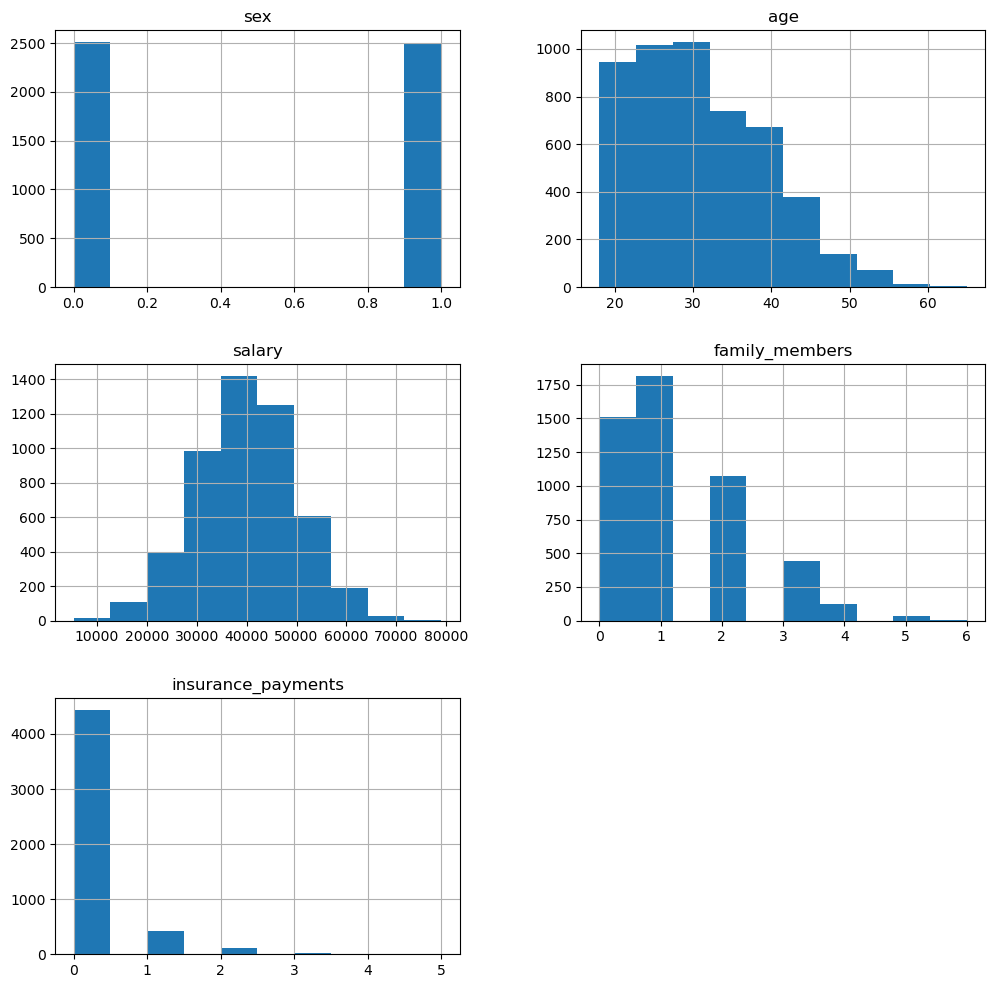

In [4]:
pers_info_1.data.hist(figsize=(12,12))
plt.show()

In [5]:
pers_info_1.data.describe()

,sex,age,salary,family_members,insurance_payments
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Данные представляют собой 5 колонок и 5000 строк.

В них входят:

1) `sex` - колонка признака, определяющая пол. Возможные значения: `1` или `0`;
2) `age` - колонка признака, определяющая возраст. В данных присутствуют значения от `18` до `65` лет;
3) `salary` - колонка признака, определяющая зарплату. Значения: `5300` - `79000`;
4) `family_members` - колонка признака, определяющая количество людей в семье. Принимает значения от от `0` до `6`;
5) `insurance_payments` - целевой признак. Определяет количество страховых выплат. Принимает значения от `0` до `5`.

Аномалий в данных не обнаружено.

Проверим дубликаты и пропуски:

In [6]:
pers_info_1.check_duplicated()

Количество дубликатов: 153


Обнаружено 153 дубликата. Посмотрим на них:

In [7]:
pers_info_1.data[pers_info_1.data.duplicated(keep=False)].sort_values(by='salary')

,sex,age,salary,family_members,insurance_payments
2955,1,32.0,21600.0,0,0
2988,1,32.0,21600.0,0,0
361,0,50.0,24700.0,1,2
2869,0,50.0,24700.0,1,2
333,0,32.0,25600.0,1,0
...,...,...,...,...,...
2465,0,40.0,54000.0,2,0
1042,0,33.0,59300.0,2,0
2231,0,33.0,59300.0,2,0
1418,1,28.0,59900.0,0,0


Удалим дубликаты:

In [8]:
pers_info_1.drop_duplicated()

In [9]:
pers_info_1.check_duplicated()

Количество дубликатов: 0


Проверим пропуски:

In [10]:
pers_info_1.check_misses()

Пропусков в данных нет


Построим корреляционную карту:

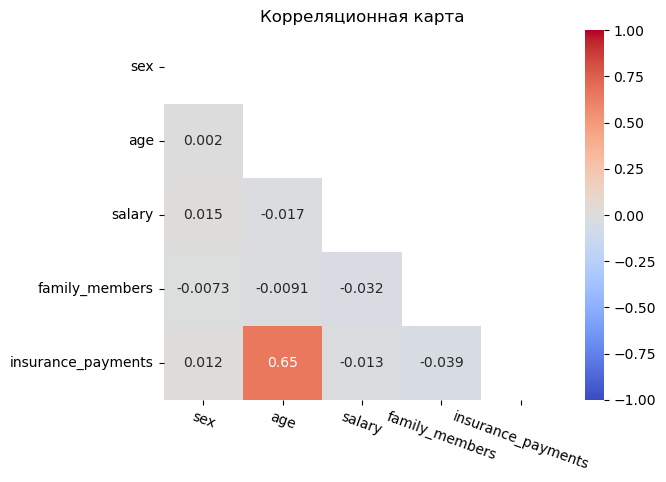

In [11]:
sns.heatmap(pers_info_1.data.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm',mask = np.triu(pers_info_1.data.corr()))
plt.xticks(rotation=-20)
plt.title('Корреляционная карта')
plt.show()

Признаки слабо коррелированны между собой. Наибольшая корреляция наблюдается у целевого признака `insurance_payments` и `age`. Рассчитаем коэффициент инфляции дисперсии:

In [12]:
pd.Series([variance_inflation_factor(add_constant(pers_info_1.data).values, i) 
               for i in range(add_constant(pers_info_1.data).shape[1])], 
              index=add_constant(pers_info_1.data).columns)

const                 40.575996
sex                    1.000469
age                    1.752399
salary                 1.001567
family_members         1.003101
insurance_payments     1.755005
dtype: float64

Коэффициента инфляции дисперсии у признаков составляет от `1` до `1.755`, что свидетельствует об отсутствии корреляции между переменной-предиктором и любыми другими переменными-предикторами в модели.

### <a id='toc1_1_3_'></a>Вывод [](#toc0_)

Данные представляют собой 5 колонок и 5000 строк. В них были обнаружены `153` дубликата. Пропусков в данных нет, аномалий также не наблюдается. 

Датасет представляет собой:

1) `sex` - колонка признака, определяющая пол. Возможные значения: `1` или `0`;
2) `age` - колонка признака, определяющая возраст. В данных присутствуют значения от `18` до `65` лет;
3) `salary` - колонка признака, определяющая зарплату. Значения: `5300` - `79000`;
4) `family_members` - колонка признака, определяющая количество людей в семье. Принимает значения от от `0` до `6`;
5) `insurance_payments` - целевой признак. Определяет количество страховых выплат. Принимает значения от `0` до `5`.

## <a id='toc1_2_'></a>Умножение матриц [](#toc0_)

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.* 

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Необходимо доказать:
$$
a = a_{v2}
$$

<div class="">
<font size="2"><b>Попытка №3</b></font>

Введем новый `признак`:

1) $X_{v2} = XP$,

В таком случае, `формула обучения` для нового признака будет иметь следующий вид:

2) $w_{v2} = (X_{v2}^TX_{v2})^{-1}X_{v2}^Ty$,

Или в полной форме:

3) $w_{v2} = ((XP)^T(XP))^{-1}(XP)^Ty$,

Преобразуем формулу:

4) $w_{v2} = (P^T X^T X P)^{-1} (XP)^T y$,
5) $w_{v2} = (P^T (X^T X) P)^{-1} P^T X^T y$,
6) $w_{v2} = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y$,

Поскольку при умножении матрицы на обратную матрицу получается единичная матрица `E`, преобразуем $(P^T)^{-1}$ и $P^T$ получим:

7) $w_{v2} = P^{-1} (X^T X)^{-1} E X^Ty$,

8) $w_{v2} = P^{-1} (X^T X)^{-1} X^Ty$,

Согласно формуле обучения, получаем:

9) $w_{v2}= P^{-1} w$,

Теперь, имея вектор весов для получим формулу предсказания:

10) $a_{v2} = X_{v2}P^{-1}w$,

Заменим на полную запись:

11) $a_{v2} = XPP^{-1}w$,

Сократим обратные матрицы:

12) $a_{v2} = XEw$,

В результате получим:

13) $a_{v2} = Xw$,

Таким образом, можно заключить, что:

14) $a = a_{v2}$.

#### <a id='toc1_2_1_1_'></a>**Ответ:** [](#toc0_)

*При умножении исходных признаков (матрицы признаков) на произвольную обратимую матрицу, качество линейной регрессии не изменится.*

## <a id='toc1_3_'></a>Алгоритм преобразования [](#toc0_)

Алгоритм преобразования можно представить следующим образом:

1) Получаем размер матрицы, которую необходимо зашифровать;
2) Создаем ключ шифрования, который представляет собой обратимую матрицу. Стоит учесть размеры матрицы: умножение матрицы на матрицу возможно, если ширина первой матрицы А ($𝑚×𝑛$) равна высоте второй матрицы В ($𝑛×r$);
3) Умножаем матрицу признаков на ключ шифрования, тем самым получая новую, зашифрованную матрицу;
4) В результате преобразования получаем новую матрицу признаков, из которой тяжело получить информацию о персональных данных. При этом данные не потеряют своей пригодности для использования их в линейной регрессии; 

## <a id='toc1_4_'></a>Проверка алгоритма [](#toc0_)

Разделим датасет на признаки и таргет:

In [13]:
pers_info_1.features_target_splitter()

Признаки содержат в себе следующие колонки: ['sex', 'age', 'salary', 'family_members']
Таргет содержит в себе следующие колонки: insurance_payments


Разделим признаки и таргет на тренированную и тестовую выборку:

In [14]:
pers_info_1.train_test_splitter()

Размер обучающей выборки составляет: 3635. Отношение к полному датасету: 75%.
Размер тестовой выборки составляет: 1212. Отношение к полному датасету: 25%.


Получим оценку r_2 для наших данных:

In [15]:
predicts_simple = pers_info_1.LinearRegression()

r2_score модели: 0.44


Создадим ключ шифрования:

In [16]:
pers_info_1.create_encryption_key()

Ключ шифрования представляет собой матрицу:

In [17]:
pers_info_1.key_encoding

array([[-0.08959304,  0.31505605,  0.43223377, -1.48537353],
       [ 1.46975723, -0.2038332 ,  0.8609464 ,  1.60473099],
       [ 0.48011109,  0.91028987, -0.6048051 ,  1.70094469],
       [ 2.86420969, -1.16431336,  1.36418763,  0.93516752]])

Проверим, как соотносятся первоначальные данные с зашифрованными:

In [18]:
pers_info_1.X_train.head(5)

,sex,age,salary,family_members
4364,1,26.0,45400.0,0
2339,1,30.0,52600.0,4
3349,1,43.0,46500.0,1
1172,1,29.0,45100.0,0
1902,1,40.0,42700.0,3


In [19]:
pers_info_1.encoding_data()

                 0             1             2             3
4364  21835.167360  41322.175576 -27435.334894  77263.126719
2339  25309.303041  47870.790067 -31781.031109  89520.088106
3349  22391.139636  42318.864957 -28084.620233  79162.381476
1172  21695.543306  41048.477115 -27251.310524  76757.657504
1902  20568.036661  38858.046317 -25786.215300  72695.847783


Из представленных данных можно сделать вывод, что по зашифрованной матрицы без дешифровки получить исходные персональные данные невозможно. Посмотрим, на дешифрованыне данные:

In [20]:
pers_info_1.decoding_data()

        0     1        2             3
4364  1.0  26.0  45400.0 -3.637979e-12
2339  1.0  30.0  52600.0  4.000000e+00
3349  1.0  43.0  46500.0  1.000000e+00
1172  1.0  29.0  45100.0 -3.637979e-12
1902  1.0  40.0  42700.0  3.000000e+00


Зашифруем данные и обучим линейную регрессию. Проверим её оценку и предсказания:

In [21]:
pers_info_1.encoding_data(print_status=False)
predicts_encoding = pers_info_1.LinearRegression(crypto=True)

r2_score модели: 0.44


In [22]:
pers_info_1.pipeline_predict()

In [23]:
print(f'Разница между предсказаниями составляет: {np.mean(pers_info_1.predictions - predicts_simple)}')

Разница между предсказаниями составляет: 2.021792799184952e-12


#### <a id='toc1_4_1_1_'></a>Вывод [](#toc0_)

1) `r_2` score имеет одинаковое значение и составляет: `0.44`;
2) Разница между предсказаниями составляет зависит от ключа шифрования, но во всех случаях стремиться к нулю. Можно заключить, что предсказания идентичны;
3) Из зашифрованных данных без предтворительной дешифровки получить информацию о персональных данных не представляется возможным. 

## <a id='toc1_5_'></a>Вывод [](#toc0_)

a) Обработка данных

* Изначальные данные содержали в себе 5 колонок и 5000 строк. Представляли собой:
   1) `sex` - колонка признака, определяющая пол. Возможные значения: `1` или `0`;
   2) `age` - колонка признака, определяющая возраст. В данных присутствуют значения от `18` до `65` лет;
   3) `salary` - колонка признака, определяющая зарплату. Значения: `5300` - `79000`;
   4) `family_members` - колонка признака, определяющая количество людей в семье. Принимает значения от от `0` до `6`;
   5) `insurance_payments` - целевой признак. Определяет количество страховых выплат. Принимает значения от `0` до `5`.
* Данные имели 153 дубликата, которые были удалены;
* Данные не имели пропусков и аномалий;

b) Умножение матриц

* Теоретическим путем было выявлено и обосновано, что при умножении исходных признаков (матрицы признаков) на произвольную обратимую матрицу, качество линейной регрессии не изменяется;

c) Алгоритм шифрования данных

  1) Получаем размер матрицы, которую необходимо зашифровать;
  2) Создаем ключ шифрования, который представляет собой обратимую матрицу. Стоит учесть размеры матрицы: умножение матрицы на матрицу возможно, если ширина первой матрицы А ($𝑚×𝑛$) равна высоте второй матрицы В ($𝑛×r$);
  3) Умножаем матрицу признаков на ключ шифрования, тем самым получая новую, зашифрованную матрицу;
  4) В результате преобразования получаем новую матрицу признаков, из которой тяжело получить информацию о персональных данных. При этом данные не потеряют своей пригодности для использования их в линейной регрессии; 
   
d) Проверка алгоритма шифрованная данных

  1) `r_2` score имеет одинаковое значение и составляет: `0.44`;
  2) Разница между предсказаниями составляет зависит от ключа шифрования, но во всех случаях стремиться к нулю. Можно заключить, что предсказания идентичны;
  3) Из зашифрованных данных без предтворительной дешифровки получить информацию о персональных данных не представляется возможным. 